# K-means
## 基本步骤
1. 数据处理：数据每个维度标准化
2. 可视化数据，确定k值蔟数
3. 初始化k个质心
4. 划分数据，根据距离（一般欧式距离）划分数据点
5. 根据划分后的类重新计算质心
6. 不断重复4、5，直到稳定，数据的划分不变，损失函数不变

* loss function：$∑∑dis(ci,x)$
每个簇所有点和质心的距离之和

In [7]:
import numpy as np
from sklearn import preprocessing

class KMeans:
    def __init__(self,data,num_clusters):
        # k值
        self.num_clusters=num_clusters
        # 数据归一化处理
        scaler=preprocessing.StandardScaler().fit(data)
        self.data=scaler.transform(data)
        
    # 随机初始化质心,返回多个质心的坐标点
    def centroids_init(self,data,num_clusters):
        num_examples=data.shape[0]   # 样本点个数
        random_ids=np.random.permutation(num_examples)
        centroids=data[random_ids[:num_clusters],:]
        return centroids
    
    # 计算最近的质心是哪一个,返回最近质心在质心里面的下标
    def find_closest_controids(self,centroids):
        num_clusters=self.num_clusters
        num_examples=self.data.shape[0]
        closest_controids_id=np.zeros((num_examples,1))
        for id in range(num_examples):
            distance=np.zeros((num_clusters,1))
            for centroid_id in range(num_clusters):
                distance[centroid_id]=np.sum((self.data[id]-centroids[centroid_id])**2)
            closest_controids_id[id]=np.argmin(distance)
        return closest_controids_id
    
    # 更新质心位置
    def update_controids(self,data,num_clusters,closest_controids_id):
        num_features=data.shape[1]  # 取特征值数量
        new_centroids=np.zeros((num_clusters,num_features))
        for id in range(num_clusters):
            indexs= closest_controids_id==id
            new_centroids[id]=np.mean(data[indexs.flatten(),:])
        return new_centroids

    # 训练模型聚类,返回质心坐标，以及每个下标所属的质心类别
    def train(self,max_iterations):
        
        num_examples=self.data.shape[0]
        # 随机选择质心
        centroids=self.centroids_init(self.data,self.num_clusters)

        for _ in range(max_iterations):
            # 计算所有点到每个质心的距离，并且返回每个点最近质心的下标
            closest_controids_id=self.find_closest_controids(centroids)

            # 根据计算结果划分类，然后重新计算质心,更新质心位置
            centroids=self.update_controids(self.data,self.num_clusters,closest_controids_id)
        return centroids,closest_controids_id



### 优点
1. 方便
### 缺点
1. k值难以确定
2. 对于形状奇怪的样本，难以得到好结果
3. 计算还是太多了，时间花销长

## 实验部分
我们拿鸢尾花数据集来做实验,为了方便展示，我们取了花瓣宽度和长度的数据

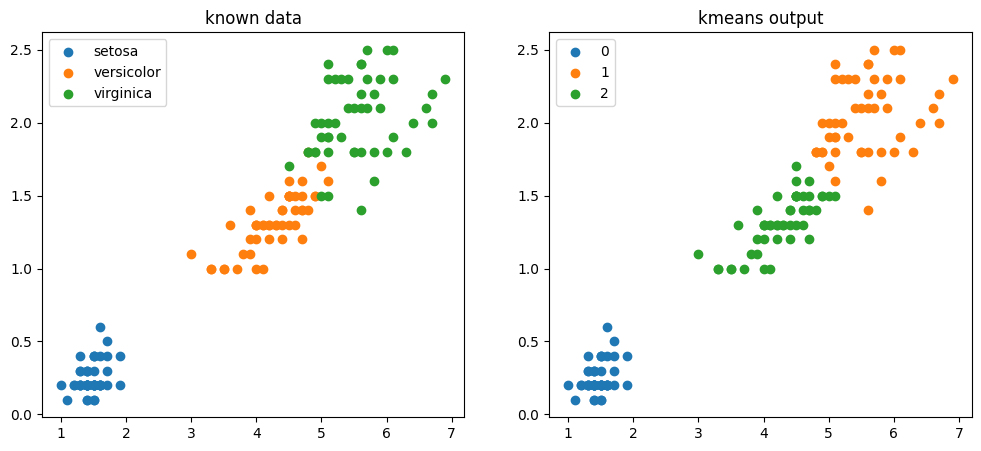

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X=data['data'][:,2:4]
y=data['target']
target_names=data['target_names']

# 画出原始数据
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for target in range(len(target_names)):
    plt.scatter(X[y==target][:,0],X[y==target][:,1],label=target_names[target])
plt.title('known data')
plt.legend()
# kmeans训练
kmeans=KMeans(X,len(np.unique(y)))
centroids,closest_controids_id=kmeans.train(50)
plt.subplot(1,2,2)
for target in range(len(np.unique(closest_controids_id))):
    plt.scatter(X[closest_controids_id[:,0]==target][:,0],X[closest_controids_id[:,0]==target][:,1],label=target)
plt.title('kmeans output')
plt.legend()

plt.show()

## sklearn实操

导入库

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans

构造数据

In [3]:
from sklearn.datasets import make_blobs
blobs_centers=np.array(
    [
        [0.2,2.3],
        [-1.5,2.3],
        [-2.8,1.8],
        [-2.8,2.8],
        [-2.8,1.3]
    ])
blob_std=np.array([0.4,0.3,0.1,0.1,0.1])
X,y=make_blobs(n_samples=2000,centers=blobs_centers,cluster_std=blob_std)

kmean实操

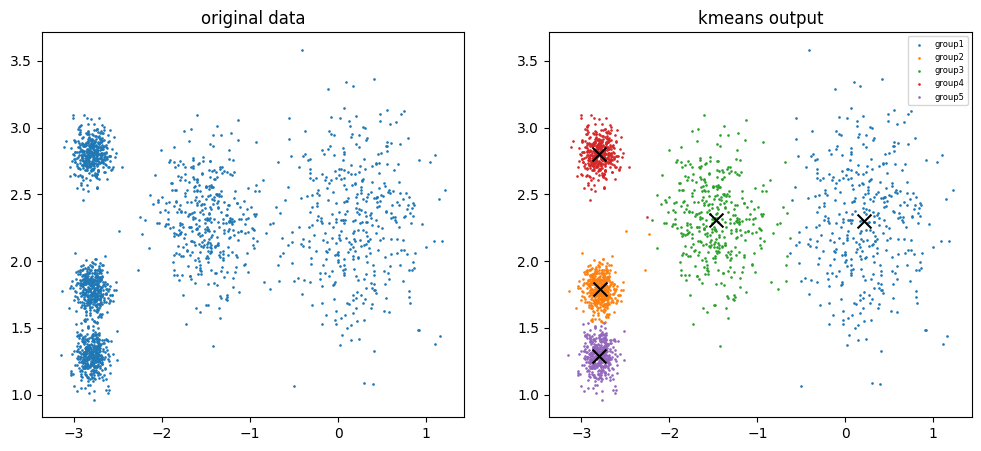

In [4]:
# 画原始图像
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],s=0.8)
plt.title('original data')

# kmean分类
num_cluster=5
kmeans=KMeans(num_cluster,n_init=50)
y_pred=kmeans.fit_predict(X)
# 获取质心坐标
cluster_centers=kmeans.cluster_centers_

plt.subplot(1,2,2)
for cluster_centers_id in range(num_cluster):
    plt.scatter(X[y_pred==cluster_centers_id][:,0],X[y_pred==cluster_centers_id][:,1],s=0.8,label=f'group{cluster_centers_id+1}')
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],s=100,marker='x',color='black')
plt.title('kmeans output')
plt.legend(loc='upper right',fontsize=6)
plt.show()

### 结果评估
* inertia指标：就是每个质心的到该类所有点到距离平方和,就是上面的损失函数

In [5]:
print(kmeans.inertia_)
print(kmeans.score(X))

222.41993805276866
-222.41993805276866


### 如何寻找最佳k值
* k值越多，inertia越小  
对于不同的k值，将inertia指标画个折线图，可以考虑用拐点位置的k值作为合适的参数

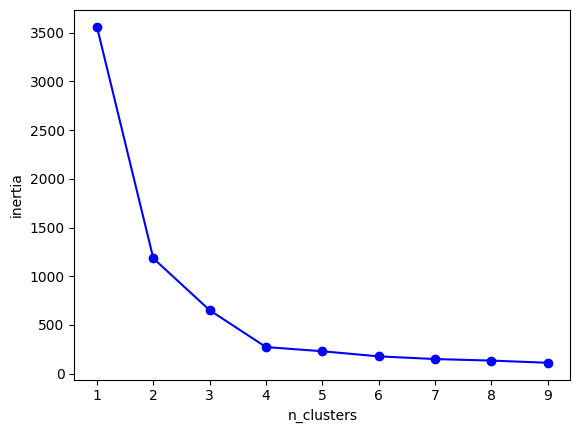

In [19]:
kmeans_per_k=[KMeans(n_clusters=k)for k in range(1,10)]
for model in kmeans_per_k:
    model.fit(X)
per_k_inertia=[model.inertia_ for model in kmeans_per_k]

#plt.figure(figsize=(12,5))
plt.plot(range(1,10),per_k_inertia,'bo-')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.show()

# 结果这里显示可以选择k=4

### 轮廓系数
* $a_i$ :计算样本$i$到同簇的其他样本的平均距离$a_i$，$a_i$被称为样本$i$的簇内不相似度  
$a_i$越小，说明越应该分到该簇
* $b_i$ :计算样本$i$到其他某簇$C_i$所有样本的平均距离$b_{ij}$，$b_i= \min \{b_{i1},b_{i2},\ldots,b_{in}\}$ ,$b_i$称为样本$i$的簇间不相似度  
$b_i$越大越好

$$
s(i) = \frac{b(i)-a(i)}{\max \{b(i),a(i)\}}
\quad \text{    } \quad
s(i) =
\begin{cases}
\ 1-\frac{a(i)}{b(i)} & a(i)<b(i) \\
\ 0 & a(i)=b(i) \\
\ \frac{b(i)}{a(i)}-1 & a(i)>b(i) 
\end{cases}
$$

### 结论：
1. $s_i$ 越接近1，说明这个点的聚类效果好
2. $s_i$ 越接近-1，说明这个点的聚类效果差，分到了错误的簇
3. $s_i$ 越接近0，说明这个点的在两个或者多个簇的边界上


* silhouette_score  
此函数返回所有样本的平均轮廓系数

[np.float64(0.6011601882016584), np.float64(0.5768609265360953), np.float64(0.6863790351890648), np.float64(0.6304158772897511), np.float64(0.5978581844548158), np.float64(0.5544819544988224), np.float64(0.5809098236948878), np.float64(0.5523372052939197)]


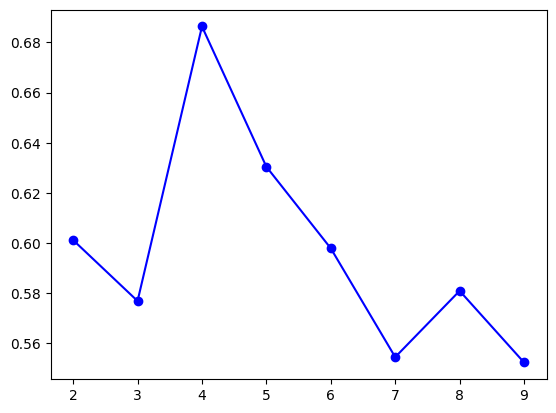

In [25]:
from sklearn.metrics import silhouette_score

per_k_silhouette_score=[silhouette_score(X,model.labels_)for model in kmeans_per_k[1:]]

plt.plot(range(2,10),per_k_silhouette_score,'bo-')
plt.show()

## 应用
1. 图像分割：  聚类色素点

## 半监督学习
1. 和逻辑回归相结合，先用聚类分类
2. 分出来的簇里面，每个簇取质心最近的点作为典型代表（这里取完之后需要自己给代表打标签），形成一个更有代表性的数据集
3. 用这个数据集再训练模型，让模型阈值更加合理